# True unit sorting quality 

author: steeve.laquitaine@epfl.ch  
last modified: 13-02-2024
status: OK  
regression: None  

Purpose
- classify true unit biases 
- count bias proportions

Methods
* Sorting is performed over entire dataset but examined for first 10 mins
* Impossible biases types are:
    * poorly detected + oversplit (impossible because poorly detected requires matching at max a single sorted unit above chance, while oversplit requires matching at least two units)
* To detect overmerged unit combinations:
    * need to look from perspective of sorted units
    * A true unit is overmerged (with other true units) if it has at least one sorted units with a score between detection and chance that also has a score between detection and chance with another true unit.
    * a poorly sorted units (accuracy between 0.1 and 0.8) can thus be overmerged (it fuse together half the spike trains of two true units). In that case it is classified as overmerged.
* Sorted unit biases
    * sorted units were matched with ground truth unit producing N ground truth pairs (each ground truth was paired with its highest accuracy sorted unit). 
    * this can produce situations where a single sorted unit can be paired with different ground truths.
    * among these pairing, we select the pairing with the highest agreement score accuracy yielding a single ground truth for each sorted unit and N sorted units pairs.
    * When the number of resulting sorted units pairs is below the number of isolated sorted single units, the missing sorted units are false positive sorted units

Updates:

* additional checks indicate that sorting accuracy might change with recording duration, so I now calculate accuracy for the first 10 mins for all experiments.


### Setup

Create or activate env `spikeinterf..`

In [ ]:
%load_ext autoreload
%autoreload 2
import os 
from matplotlib import pyplot as plt
import warnings
import numpy as np
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

proj_path = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(proj_path)

from src.nodes.postpro import cell_matching as cm
from src.nodes.utils import get_config

# matching parameters
DT = 1.3  # ms - the delta_time: window that defines the match of two spikes between true and sorted units

# classification parameters
LOW_RATE_CEILING = 0.2  # max firing rate where negative proba change is observed in "bias plot" (sparse units)
GOOD_THR = 0.8
CHANCE_THR = 0.1

# sampling frequencies
SF_B = 32000
SF_M = 40000
SF_H = 20000
SF_E = 20000

# buccino
data_conf, param_conf = get_config("buccino_2020", "2020").values()
GT_B = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
SORTED_B_KS3 = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
SORTED_B_KS25 = data_conf["sorting"]["sorters"]["kilosort2_5"]["output"]
SORTED_B_KS2 = data_conf["sorting"]["sorters"]["kilosort2"]["output"]
SORTED_B_KS = data_conf["sorting"]["sorters"]["kilosort"]["output"]
SORTED_B_HS = data_conf["sorting"]["sorters"]["herdingspikes"]["output"]

# silico marques
data_conf, param_conf = get_config("silico_neuropixels", "concatenated").values()
GT_M = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
SORTED_M_KS3 = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
SORTED_M_KS25 = data_conf["sorting"]["sorters"]["kilosort2_5"]["output"]
SORTED_M_KS2 = data_conf["sorting"]["sorters"]["kilosort2"]["output"]
SORTED_M_KS = data_conf["sorting"]["sorters"]["kilosort"]["output"]
SORTED_M_HS = data_conf["sorting"]["sorters"]["herdingspikes"]["output"]

# silico horvath
data_conf, param_conf = get_config("silico_horvath", "concatenated/probe_1").values()
GT_H = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
SORTED_H_KS3 = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
SORTED_H_KS25 = data_conf["sorting"]["sorters"]["kilosort2_5"]["output"]
SORTED_H_KS2 = data_conf["sorting"]["sorters"]["kilosort2"]["output"]
SORTED_H_KS = data_conf["sorting"]["sorters"]["kilosort"]["output"]
SORTED_H_HS = data_conf["sorting"]["sorters"]["herdingspikes"]["output"]

# silico stimulus
data_conf, param_conf = get_config("silico_neuropixels", "stimulus").values()
GT_E = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
SORTED_E_KS3 = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
SORTED_E_KS25 = data_conf["sorting"]["sorters"]["kilosort2_5"]["output"]
SORTED_E_KS2 = data_conf["sorting"]["sorters"]["kilosort2"]["output"]
SORTED_E_KS = data_conf["sorting"]["sorters"]["kilosort"]["output"]
SORTED_E_HS = data_conf["sorting"]["sorters"]["herdingspikes"]["output"]


# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)

# set colors for combination of biases
oversplit_plus_overmerged = np.array([[0.6, 0.9, 0.6], [0, 0.7, 1]]).mean(axis=0)
well_detected_plus_correlated_units_plus_overmerged = np.array(
    [[1, 0, 0], [0, 0.7, 1]]
).mean(axis=0)

# set all colors
colors = [
    [0.7, 0.1, 0.1],  # "well_detected" (strong red)
    [1, 0, 0],        # "well_detected_plus_correlated_units" (red)
    well_detected_plus_correlated_units_plus_overmerged,
    [1, 0.85, 0.85],  # "poorly_detected" (pink)
    [0, 0.7, 1],  # "overmerged" (green)
    [0.6, 0.9, 0.6],  # "oversplit" (blue)
    oversplit_plus_overmerged,
    [0.95, 0.95, 0.95],  # "below chance"
    "k",  # "missed"
]


BOX_ASPECT = 1                  # square fig
FIG_SIZE = (0.7, 0.5)
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.2
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True}
# print(plt.rcParams.keys())

2024-06-18 11:41:09,956 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-18 11:41:09,993 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-18 11:41:09,994 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-18 11:41:10,068 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-18 11:41:10,069 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-18 11:41:10,111 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-18 11:41:10,112 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-18 11:41:10,138 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Parametrize

Parametrize recording datasets

In [37]:
# parametrize
recordings = ["B", "M", "H", "E"]
true_paths = [GT_B, GT_M, GT_H, GT_E]
sfreqs = [SF_B, SF_M, SF_H, SF_E]

### (30s)KS 3.0

combination of biases: ['good + corr' 'oversplit' 'poor']
combination of biases: ['good + corr' 'oversplit' 'poor']
combination of biases: ['oversplit' 'poor']
combination of biases: ['good + corr' 'oversplit' 'poor']


,B,M,H,E
good,186,99,3,160
good + corr,23,21,1,7
good + corr + overmerged,4,8,0,1
poor,8,38,2,90
overmerged,3,47,7,32
oversplit,9,9,2,24
oversplit + overmerged,4,10,1,18
below chance,13,1011,129,1262
missed,0,145,142,242


,B,M,H,E
good,0.744,0.071326,0.010453,0.087146
good + corr,0.092,0.015130,0.003484,0.003813
good + corr + overmerged,0.016,0.005764,0.000000,0.000545
poor,0.032,0.027378,0.006969,0.049020
overmerged,0.012,0.033862,0.024390,0.017429
oversplit,0.036,0.006484,0.006969,0.013072
oversplit + overmerged,0.016,0.007205,0.003484,0.009804
below chance,0.052,0.728386,0.449477,0.687364
missed,0.000,0.104467,0.494774,0.131808


0.22823114489659252
0.3454317156478309


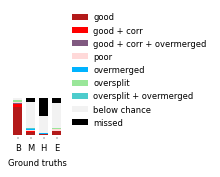

In [67]:
# parametrize
sorted_paths = [SORTED_B_KS3, SORTED_M_KS3, SORTED_H_KS3, SORTED_E_KS3]

# compute true unit quality for each recording
data_df = cm.compute_true_units_quality(
    recordings,
    true_paths,
    sorted_paths,
    sfreqs,
    GOOD_THR,
    CHANCE_THR,
    DT,
)

# plot
fig, axis = plt.subplots(1, 1, figsize=FIG_SIZE)
axis = cm.plot_true_units_quality(axis, data_df)

# legend
# disconnected axes
axis.set_xlabel("Ground truths")
axis.spines["bottom"].set_position(("axes", -0.05))
axis.set_ylabel("Proportion (ratio)")
axis.spines["left"].set_position(("axes", -0.05))

# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/1_quality/fig5e/ks3.svg",
    **savefig_cfg,
)

# data
display(data_df)  # count
display(data_df / data_df.sum())  # ratio

# stats for "good"
good_ratios = (data_df / data_df.sum()).loc["good"]
print(good_ratios.mean())
print(good_ratios.std())

### (30s)KS 2.5

combination of biases: ['good + corr']
combination of biases: ['good + corr' 'oversplit' 'poor']
combination of biases: []
combination of biases: ['good + corr' 'oversplit' 'poor']


,B,M,H,E
good,223,89,1,128
good + corr,18,13,0,1
good + corr + overmerged,4,6,0,6
poor,0,12,0,21
overmerged,0,52,0,36
oversplit,0,0,0,0
oversplit + overmerged,0,1,0,8
below chance,5,1079,69,1382
missed,0,136,217,254


,B,M,H,E
good,0.892,0.064121,0.003484,0.069717
good + corr,0.072,0.009366,0.000000,0.000545
good + corr + overmerged,0.016,0.004323,0.000000,0.003268
poor,0.000,0.008646,0.000000,0.011438
overmerged,0.000,0.037464,0.000000,0.019608
oversplit,0.000,0.000000,0.000000,0.000000
oversplit + overmerged,0.000,0.000720,0.000000,0.004357
below chance,0.020,0.777378,0.240418,0.752723
missed,0.000,0.097983,0.756098,0.138344


0.25733053340514916
0.4241745171682794


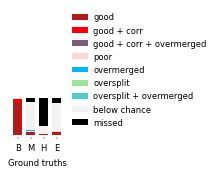

In [68]:
# parametrize
sorted_paths = [SORTED_B_KS25, SORTED_M_KS25, SORTED_H_KS25, SORTED_E_KS25]

# compute true unit quality for each recording
data_df = cm.compute_true_units_quality(
    recordings,
    true_paths,
    sorted_paths,
    sfreqs,
    GOOD_THR,
    CHANCE_THR,
    DT,
)

# plot
fig, axis = plt.subplots(1, 1, figsize=FIG_SIZE)
axis = cm.plot_true_units_quality(axis, data_df)

# legend
# disconnected axes
axis.set_xlabel("Ground truths")
axis.spines["bottom"].set_position(("axes", -0.05))
axis.set_ylabel("Proportion (ratio)")
axis.spines["left"].set_position(("axes", -0.05))

# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/1_quality/fig5e/ks2_5.svg",
    **savefig_cfg,
)

# data
display(data_df)  # count
display(data_df / data_df.sum())  # ratio

# stats for "good"
good_ratios = (data_df / data_df.sum()).loc["good"]
print(good_ratios.mean())
print(good_ratios.std())

### (30s)KS 2.0

combination of biases: ['good + corr']
combination of biases: ['good + corr' 'oversplit' 'poor']
combination of biases: ['poor']


,B,M,H
good,231,81,1
good + corr,9,21,0
good + corr + overmerged,3,2,0
poor,0,27,0
overmerged,0,53,2
oversplit,0,1,0
oversplit + overmerged,0,4,0
below chance,7,1081,66
missed,0,118,218


,B,M,H
good,0.924,0.058357,0.003484
good + corr,0.036,0.015130,0.000000
good + corr + overmerged,0.012,0.001441,0.000000
poor,0.000,0.019452,0.000000
overmerged,0.000,0.038184,0.006969
oversplit,0.000,0.000720,0.000000
oversplit + overmerged,0.000,0.002882,0.000000
below chance,0.028,0.778818,0.229965
missed,0.000,0.085014,0.759582


0.32861388975355377
0.5163489396815532


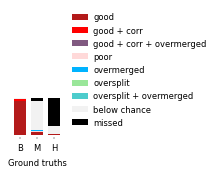

In [69]:
recordings = ["B", "M", "H"]
true_paths = [GT_B, GT_M, GT_H]
sfreqs = [SF_B, SF_M, SF_H]

# parametrize
sorted_paths = [SORTED_B_KS2, SORTED_M_KS2, SORTED_H_KS2]  # , SORTED_E_KS2]

# compute true unit quality for each recording
data_df = cm.compute_true_units_quality(
    recordings,
    true_paths,
    sorted_paths,
    sfreqs,
    GOOD_THR,
    CHANCE_THR,
    DT,
)

# plot
fig, axis = plt.subplots(1, 1, figsize=FIG_SIZE)
axis = cm.plot_true_units_quality(axis, data_df)

# legend
# disconnected axes
axis.set_xlabel("Ground truths")
axis.spines["bottom"].set_position(("axes", -0.05))
axis.set_ylabel("Proportion (ratio)")
axis.spines["left"].set_position(("axes", -0.05))

# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/1_quality/fig5e/ks2.svg",
    **savefig_cfg,
)

# data
display(data_df)  # count
display(data_df / data_df.sum())  # ratio

# stats for "good"
good_ratios = (data_df / data_df.sum()).loc["good"]
print(good_ratios.mean())
print(good_ratios.std())

### (30s)KS

combination of biases: ['good + corr' 'poor']
combination of biases: ['good + corr' 'oversplit' 'poor']
combination of biases: ['good + corr' 'oversplit' 'poor']
combination of biases: ['good + corr' 'oversplit' 'poor']


,B,M,H,E
good,177,152,24,173
good + corr,9,27,8,17
good + corr + overmerged,2,73,26,16
poor,1,94,9,111
overmerged,9,102,32,84
oversplit,49,77,11,148
oversplit + overmerged,0,147,41,91
below chance,3,638,120,981
missed,0,78,16,215


,B,M,H,E
good,0.708,0.109510,0.083624,0.094227
good + corr,0.036,0.019452,0.027875,0.009259
good + corr + overmerged,0.008,0.052594,0.090592,0.008715
poor,0.004,0.067723,0.031359,0.060458
overmerged,0.036,0.073487,0.111498,0.045752
oversplit,0.196,0.055476,0.038328,0.080610
oversplit + overmerged,0.000,0.105908,0.142857,0.049564
below chance,0.012,0.459654,0.418118,0.534314
missed,0.000,0.056196,0.055749,0.117102


0.24884008983895486
0.30629096633422775


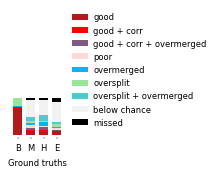

In [70]:
# parametrize
recordings = ["B", "M", "H", "E"]
true_paths = [GT_B, GT_M, GT_H, GT_E]
sfreqs = [SF_B, SF_M, SF_H, SF_E]

# parametrize
sorted_paths = [SORTED_B_KS, SORTED_M_KS, SORTED_H_KS, SORTED_E_KS]

# compute true unit quality for each recording
data_df = cm.compute_true_units_quality(
    recordings,
    true_paths,
    sorted_paths,
    sfreqs,
    GOOD_THR,
    CHANCE_THR,
    DT,
)

# plot
fig, axis = plt.subplots(1, 1, figsize=FIG_SIZE)
axis = cm.plot_true_units_quality(axis, data_df)

# legend
# disconnected axes
axis.set_xlabel("Ground truths")
axis.spines["bottom"].set_position(("axes", -0.05))
axis.set_ylabel("Proportion (ratio)")
axis.spines["left"].set_position(("axes", -0.05))

# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/1_quality/fig5e/ks.svg",
    **savefig_cfg,
)

# data
display(data_df)  # count
display(data_df / data_df.sum())  # ratio

# stats for "good"
good_ratios = (data_df / data_df.sum()).loc["good"]
print(good_ratios.mean())
print(good_ratios.std())

### (20s)HS

combination of biases: ['poor']
combination of biases: ['good + corr' 'oversplit' 'poor']
combination of biases: ['good + corr' 'oversplit' 'poor']
combination of biases: ['good + corr' 'oversplit' 'poor']


,B,M,H,E
good,115,106,7,77
good + corr,7,7,1,3
good + corr + overmerged,0,18,1,8
poor,54,60,5,95
overmerged,8,95,54,125
oversplit,3,3,0,7
oversplit + overmerged,0,12,13,20
below chance,63,909,115,1265
missed,0,178,91,236


,B,M,H,E
good,0.460,0.076369,0.024390,0.041939
good + corr,0.028,0.005043,0.003484,0.001634
good + corr + overmerged,0.000,0.012968,0.003484,0.004357
poor,0.216,0.043228,0.017422,0.051743
overmerged,0.032,0.068444,0.188153,0.068083
oversplit,0.012,0.002161,0.000000,0.003813
oversplit + overmerged,0.000,0.008646,0.045296,0.010893
below chance,0.252,0.654899,0.400697,0.688998
missed,0.000,0.128242,0.317073,0.128540


0.15067452945112036
0.20734408878998026


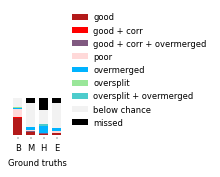

In [71]:
# parametrize
sorted_paths = [SORTED_B_HS, SORTED_M_HS, SORTED_H_HS, SORTED_E_HS]

# compute true unit quality for each recording
data_df = cm.compute_true_units_quality(
    recordings,
    true_paths,
    sorted_paths,
    sfreqs,
    GOOD_THR,
    CHANCE_THR,
    DT,
)

# plot
fig, axis = plt.subplots(1, 1, figsize=FIG_SIZE)
axis = cm.plot_true_units_quality(axis, data_df)

# legend
# disconnected axes
axis.set_xlabel("Ground truths")
axis.spines["bottom"].set_position(("axes", -0.05))
axis.set_ylabel("Proportion (ratio)")
axis.spines["left"].set_position(("axes", -0.05))

# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/1_quality/fig5e/hs.svg",
    **savefig_cfg,
)

# data
display(data_df)  # count
display(data_df / data_df.sum())  # ratio

# stats for "good"
good_ratios = (data_df / data_df.sum()).loc["good"]
print(good_ratios.mean())
print(good_ratios.std())